In [1]:
import astropy
import astropy.units as u
import astroquery
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.time import Time 
import os
from astropy.io.votable import parse_single_table
from astropy.time import Time
import pytest
from astropy.table import Table, vstack
import csv
import pandas as pd

%matplotlib inline

In [21]:
# First write a script to make such a plot for a single pulsar, choose a fun one :)
# PSR J0348+0432

# define necessary variables as strings 
ra = Angle('03:48:43.639000', unit = u.hourangle)
dec = Angle('+04:32:11.4580', unit = u.deg)


pmra = u.Quantity(+4.04, u.mas/u.yr)
pmdec = u.Quantity(+3.5, u.mas/u.yr)

posepoch = Time(56000.00, format='mjd').jyear

psr = SkyCoord(ra= '03:48:43.639000', dec= '+04:32:11.4580', unit= (u.hourangle, u.deg), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)

# ok now we have to deal with the errors on pos and pm
ra_err_str = '4.0e-06'
if 'e' in ra_err_str:
    base, exp = ra_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    ra_err = Angle(num, unit = u.hourangle)
else:
    num = float(ra_err_str)
    ra_err = Angle(num, unit = u.hourangle)


dec_err_str = '2.0e-04'
if 'e' in dec_err_str:
    base, exp = dec_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    dec_err = Angle(num, unit = u.deg)
else:
    num = float(dec_err_str)
    dec_err = Angle(num, unit = u.deg)

pmra_err_str = '1.6e-01'
if 'e' in pmra_err_str:
    base, exp = pmra_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    pmra_err = Angle(num, unit = u.mas)  / u.yr
else:
    num = float(pmra_err_str)
    pmra_err = Angle(num, unit = u.mas)  / u.yr

pmdec_err_str = '6.0e-01'
if 'e' in pmdec_err_str:
    base, exp = pmdec_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    pmdec_err = Angle(num, unit = u.mas) /u.yr
else:
    num = float(pmdec_err_str)
    pmdec_err = Angle(num, unit = u.mas) / u.yr

215.99999999999997
0.16000000000000003 mas / yr
216.52824093086923


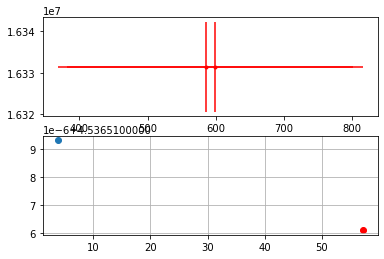

In [30]:
# let's make sure we're able simply to propogate the error on (ra and pmra) and (dec and pmdec)

dr2epoch = Time('2015.5', format='jyear').jyear
dr3epoch = Time('2016.0', format='jyear').jyear
epoch_diff_dr2 = (dr2epoch.tolist() * u.yr) - (posepoch.tolist() * u.yr)
epoch_diff_dr3 = (dr3epoch.tolist() * u.yr) - (posepoch.tolist() * u.yr)

# psr.ra.mas
# psr.dec
#print(psr.pm_ra_cosdec)
# psr.pm_dec.to(u.hourangle / u.yr)
# pmra_err.to(u.mas / u.yr)


prop_ra_dr2 = psr.ra.mas * u.mas + (psr.pm_ra_cosdec * epoch_diff_dr2)
prop_dec_dr2 = psr.dec.mas * u.mas + (psr.pm_dec * epoch_diff_dr2)

prop_ra_dr3 = psr.ra.mas * u.mas + (psr.pm_ra_cosdec * epoch_diff_dr3)
prop_dec_dr3 = psr.dec.mas * u.mas + (psr.pm_dec * epoch_diff_dr3)

prop_ra_err_dr2 = ra_err.mas * u.mas + (pmra_err * epoch_diff_dr2)
prop_dec_err_dr2 = dec_err.mas * u.mas + (pmdec_err * epoch_diff_dr2)

prop_ra_err_dr3 = ra_err.mas * u.mas + (pmra_err * epoch_diff_dr3)
prop_dec_err_dr3 = dec_err.mas * u.mas + (pmdec_err * epoch_diff_dr3)

# print(psr.ra.mas)
# print(prop_ra_dr2)
# print(prop_ra_err_dr2)

print(ra_err.mas)
print(pmra_err)
print(prop_ra_err_dr2.value)

# define a new skycoord object with the propogated positions
prop_psr_dr2 = SkyCoord(ra= prop_ra_dr2, dec= prop_dec_dr2, unit= (u.mas, u.mas), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)
prop_psr_dr3 = SkyCoord(ra= prop_ra_dr3, dec= prop_dec_dr3, unit= (u.mas, u.mas), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)


# fig = plt.figure()
# ax = plt.subplot(111)
# ax.grid(True)
# ax.scatter(psr.ra.mas, psr.dec.mas, color= 'r')
# ax.errorbar(x= psr.ra.mas, y= psr.dec.mas, xerr= ra_err.mas, yerr= dec_err.mas, color= 'r')
# ax.scatter(prop_ra_dr2.value, prop_dec_dr2.value)
# ax.errorbar(x= prop_ra_dr2.value, y= prop_dec_dr2.value, xerr= prop_ra_err_dr2.value, yerr= prop_dec_err_dr2.value, fmt= '.')


fig, axs = plt.subplots(2)
plt.grid(True)
axs[1].scatter(psr.ra, psr.dec, color= 'r')
axs[0].errorbar(x= [psr.ra.mas, prop_ra_dr2.value], y= [psr.dec.mas, prop_dec_dr2.value], xerr= [ra_err.mas, prop_ra_err_dr2.value], yerr= [dec_err.mas, prop_dec_err_dr2.value], fmt= 'r.')
axs[1].scatter(prop_psr_dr2.ra.hourangle, prop_psr_dr2.dec.deg)
#plt.errorbar(x= prop_ra_dr2.value, y= prop_dec_dr2.value+100, xerr= prop_ra_err_dr2.value, yerr= prop_dec_err_dr2.value, fmt= '.')

[57.18182917 57.18183029]
[4.53651611 4.53651708]
57d10m54.585s
4d32m11.458s


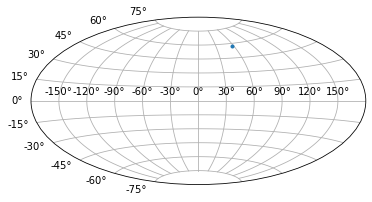

In [46]:
# now its time to actually plot this thing up!

# plot units consistently!! let's do everything in hms dms

# for aitoff projection we need to be in radians

ra_rad = psr.ra.wrap_at(180 * u.deg).radian
dec_rad = psr.ra.wrap_at(180 * u.deg).radian

pmra_vec = ra_rad + (psr.pm_ra_cosdec*u.yr)
pmdec_vec = dec_rad + (psr.pm_dec*u.yr)
# print(ra)
# print(pmra.to(u.hourangle / u.yr))
# print(pmra_vec)

pmra_arr = np.array([psr.ra.value, pmra_vec.value])
pmdec_arr = np.array([psr.dec.value, pmdec_vec.value])

print(pmra_arr)
print(pmdec_arr)
print(psr.ra)
print(psr.dec)

fig = plt.figure()
ax = plt.subplot(111, projection= 'aitoff')
ax.grid(True)
ax.errorbar(x= ra_rad, y= ra_rad, xerr= ra_err.value, yerr= dec_err.value, fmt= '.')
ax.plot(pmra_arr, pmdec_arr)

I think regarding the plots, for just looking at one psr at a time, it is ok to plot in cartesian space, as it's
just to get a pictorial sense of what's going on